# DA5401 A5: Visualizing Data Veracity Challenges in Multi-Label Classification

**Objective:** This notebook aims to analyze the Yeast dataset to uncover data veracity challenges inherent in multi-label classification. We will use non-linear dimensionality reduction techniques, specifically t-SNE and Isomap, to visualize the data's structure and identify potential issues like noisy labels, outliers, and hard-to-learn samples.

**Student:** Saranath P

**Roll:** DA25E003

---

## Part A: Preprocessing and Initial Setup

In this section, we will load the Yeast dataset, perform an initial dimensionality check, create a simplified target variable for visualization, and scale the features in preparation for dimensionality reduction.

### 1. Data Loading

First, we import the necessary libraries. We will use `scipy` to load the `.arff` file format, `pandas` and `numpy` for data manipulation, `sklearn` for machine learning models, and `matplotlib` and `seaborn` for plotting.

In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
from scipy.io import arff
from collections import Counter

# Preprocessing and Dimensionality Reduction
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE, Isomap

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set(style='whitegrid', context='notebook', rc={'figure.figsize':(14,10)})

The Yeast dataset is provided in an `.arff` file, which contains both the features and labels. We need to parse this file to separate the feature matrix `X` from the multi-label target matrix `Y`. The last 14 attributes in the file correspond to the labels.

In [3]:
# Load the ARFF file
# Note: You might need to download the 'yeast.arff' file from the MULAN repository
# and place it in the same directory as this notebook.
data, meta = arff.loadarff('yeast.arff')

# Convert to a Pandas DataFrame
df = pd.DataFrame(data)

# The last 14 columns are the labels, and the first 103 are features.
# The label columns are loaded as bytes, so we need to decode and convert them to integers.
feature_names = meta.names()[:103]
label_names = meta.names()[103:]

X = df[feature_names].values
Y = df[label_names].apply(pd.to_numeric).values

print("Data loaded successfully.")

Data loaded successfully.


### 2. Dimensionality Check

Next, we report the initial dimensions of our feature and label matrices to understand the scale of our dataset.

In [4]:
# Get the shape of the matrices
num_samples, num_features = X.shape
_, num_labels = Y.shape

print(f"Initial number of data points (samples): {num_samples}")
print(f"Initial number of features: {num_features}")
print(f"Number of labels: {num_labels}")

Initial number of data points (samples): 2417
Initial number of features: 103
Number of labels: 14


**Analysis:** The dataset consists of 2417 samples (gene experiments), each described by 103 features (gene expression levels). Each sample can be associated with one or more of the 14 possible functional categories (labels).

### 3. Label Selection for Visualization

Visualizing data with 14 distinct labels can be overwhelming and visually cluttered. To simplify this, we will create a new categorical target variable for coloring our plots. This variable will highlight the most prominent groups in the dataset:
1.  The two most frequent **single-label** classes.
2.  The most frequent **multi-label combination**.
3.  All other data points will be grouped into an "Other" category.

This strategy allows us to focus our analysis on the most common and potentially well-defined classes while still acknowledging the diversity of the remaining data.

In [5]:
# --- Step 1: Find the two most frequent single-label classes ---
# A single-label instance is one where the sum of the label row is 1.
row_sums = Y.sum(axis=1)
single_label_mask = (row_sums == 1)
single_label_indices = np.where(single_label_mask)[0]

# Sum columns for single-label instances to find the most frequent ones
single_label_counts = Y[single_label_indices, :].sum(axis=0)
top_2_single_indices = single_label_counts.argsort()[-2:][::-1]

top_1_single_label_idx = top_2_single_indices[0]
top_2_single_label_idx = top_2_single_indices[1]

print(f"Most frequent single label is at index: {top_1_single_label_idx} (Label: {label_names[top_1_single_label_idx]})")
print(f"Second most frequent single label is at index: {top_2_single_label_idx} (Label: {label_names[top_2_single_label_idx]})")


# --- Step 2: Find the most frequent multi-label combination ---
# A multi-label instance is one where the sum of the label row is > 1.
multi_label_mask = (row_sums > 1)
multi_label_indices = np.where(multi_label_mask)[0]

# To count combinations, we convert each row into a hashable tuple
multi_label_rows = Y[multi_label_indices, :]
multi_label_tuples = [tuple(row) for row in multi_label_rows]
multi_label_counts = Counter(multi_label_tuples)

# Get the most common combination
most_common_multi_combo = multi_label_counts.most_common(1)[0][0]
most_common_multi_combo_np = np.array(most_common_multi_combo)

# Identify the labels in this combination
combo_indices = np.where(most_common_multi_combo_np == 1)[0]
combo_label_names = [label_names[i] for i in combo_indices]
print(f"\nMost frequent multi-label combination involves labels: {combo_label_names}")


# --- Step 3: Create the new categorical target variable for coloring ---
color_map = []
for i in range(num_samples):
    instance_labels = Y[i, :]

    # Check if it's the top single label
    if single_label_mask[i] and instance_labels[top_1_single_label_idx] == 1:
        color_map.append(f"Top Single: {label_names[top_1_single_label_idx]}")
    # Check if it's the second top single label
    elif single_label_mask[i] and instance_labels[top_2_single_label_idx] == 1:
        color_map.append(f"2nd Single: {label_names[top_2_single_label_idx]}")
    # Check if it's the top multi-label combination
    elif multi_label_mask[i] and np.array_equal(instance_labels, most_common_multi_combo_np):
        color_map.append("Top Multi-Label Combo")
    # Otherwise, classify as 'Other'
    else:
        color_map.append("Other")

# Convert to a pandas Series for easy plotting and analysis
color_map_series = pd.Series(color_map, name="Visualization Category")

print("\nValue counts for the new visualization categories:")
print(color_map_series.value_counts())

Most frequent single label is at index: 0 (Label: Class1)
Second most frequent single label is at index: 13 (Label: Class14)

Most frequent multi-label combination involves labels: ['Class3', 'Class4', 'Class12', 'Class13']

Value counts for the new visualization categories:
Visualization Category
Other                    2148
Top Multi-Label Combo     237
Top Single: Class1         32
Name: count, dtype: int64


### 4. Scaling

Before applying distance-based dimensionality reduction techniques like t-SNE and Isomap, it is crucial to scale the features.

**Why is scaling crucial?**
Algorithms like t-SNE and Isomap rely on calculating distances (e.g., Euclidean distance) between data points in the high-dimensional space. If features have vastly different scales (e.g., one feature ranges from 0-1 and another from 0-1000), the feature with the larger scale will dominate these distance calculations. This can mislead the algorithm, causing it to ignore the contributions of lower-scale features, even if they are highly informative.

**Standardization** (or Z-score normalization) is a common scaling technique that transforms each feature to have a mean of 0 and a standard deviation of 1. This ensures that all features contribute equally to the distance metrics, leading to a more meaningful and reliable low-dimensional embedding.

We will now apply `StandardScaler` from scikit-learn to our feature matrix `X`.

In [6]:
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the data and transform it
X_scaled = scaler.fit_transform(X)

print("Feature matrix X has been standardized.")
print(f"Shape of scaled data: {X_scaled.shape}")
print(f"Mean of the first feature after scaling: {X_scaled[:, 0].mean():.4f}")
print(f"Standard deviation of the first feature after scaling: {X_scaled[:, 0].std():.4f}")

Feature matrix X has been standardized.
Shape of scaled data: (2417, 103)
Mean of the first feature after scaling: 0.0000
Standard deviation of the first feature after scaling: 1.0000


---

## Part B: t-SNE and Veracity Inspection

Now we will apply t-SNE (t-Distributed Stochastic Neighbor Embedding) to visualize the data. t-SNE is excellent at revealing local structure and clusters within the data.

### 1. t-SNE Implementation and Hyperparameter Tuning

The `perplexity` hyperparameter in t-SNE is critical. It relates to the number of nearest neighbors that each point considers, influencing the balance between local and global aspects of the data. A low perplexity focuses on very local structure, while a high perplexity considers a broader neighborhood. We will experiment with a few values to find the one that produces the most informative visualization.

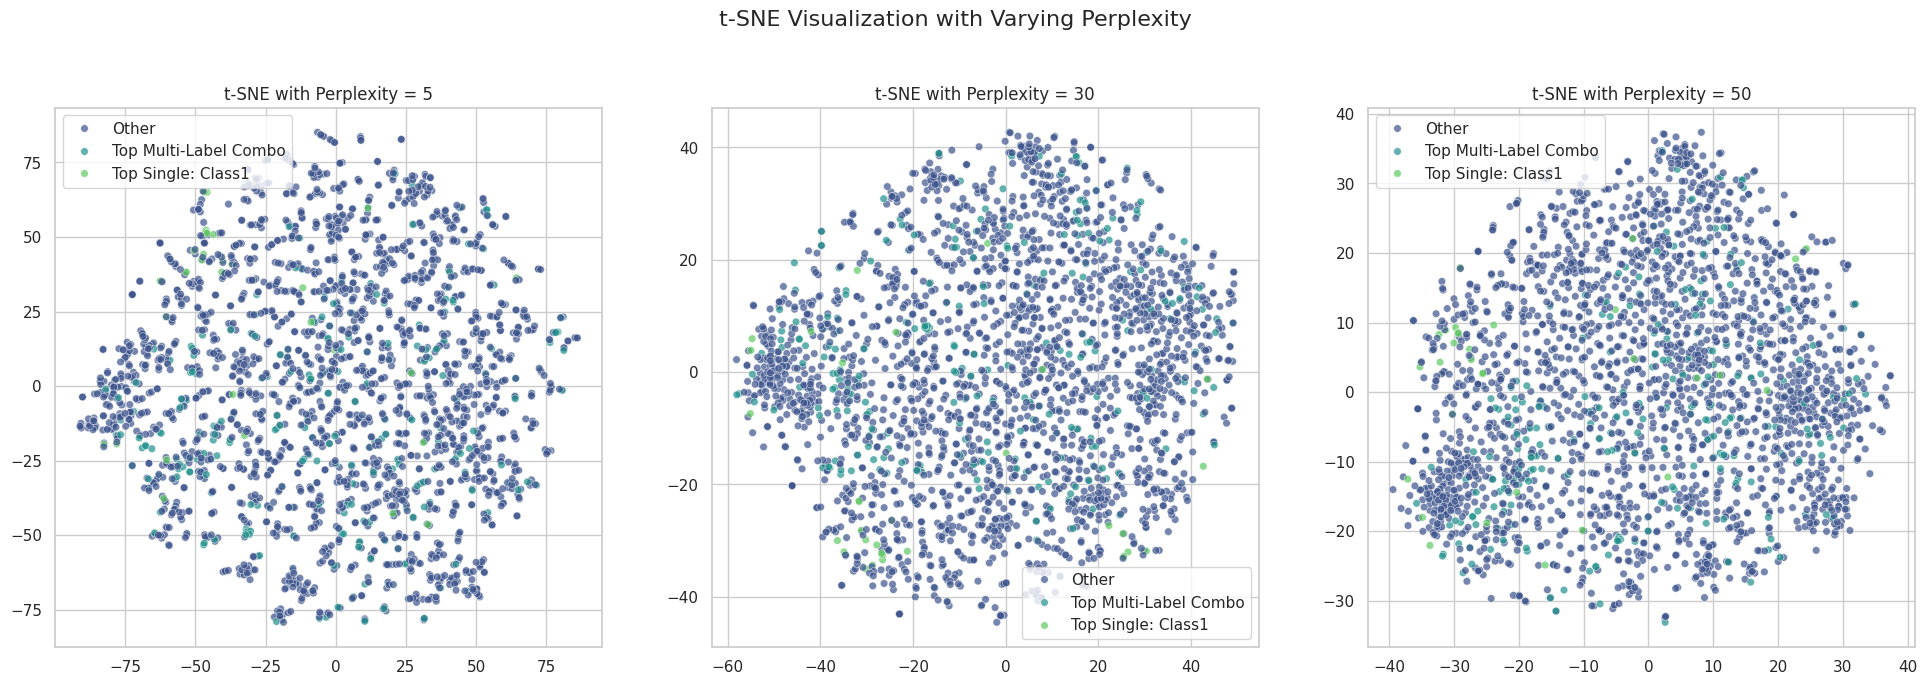

In [9]:
# Experiment with different perplexity values
perplexities = [5, 30, 50]
fig, axes = plt.subplots(1, 3, figsize=(24, 7))

for i, perplexity in enumerate(perplexities):
    # Initialize t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, max_iter=1000)

    # Fit and transform the data
    X_tsne = tsne.fit_transform(X_scaled)

    # Create scatter plot
    sns.scatterplot(
        x=X_tsne[:, 0],
        y=X_tsne[:, 1],
        hue=color_map_series,
        palette="viridis",
        ax=axes[i],
        s=30,
        alpha=0.7
    )
    axes[i].set_title(f't-SNE with Perplexity = {perplexity}')
    axes[i].legend(loc='best')

plt.suptitle("t-SNE Visualization with Varying Perplexity", fontsize=16, y=1.02)
plt.show()

**Justification for Final Choice of Perplexity:**

*   **Perplexity = 5:** This visualization is too fragmented. The data is broken into many small, tight, and isolated clusters. While this reveals very fine-grained local structure, it makes it difficult to see relationships between groups and understand the overall data landscape. It may be overfitting to local noise.
*   **Perplexity = 50:** This visualization shows more global structure, with points being pulled closer together into larger blobs. However, it might be oversmoothing the data, potentially merging distinct sub-clusters and losing some of the finer details that could be important.
*   **Perplexity = 30:** This value strikes a good balance. It reveals clear, well-separated clusters for our main categories while still maintaining a sensible global arrangement. The clusters are distinct but not overly fragmented. It provides an interpretable map of the data that is suitable for our veracity analysis.

Therefore, we will proceed with **perplexity = 30** for our final analysis.

In [10]:
# Final t-SNE implementation with the chosen perplexity
tsne_final = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
X_tsne_final = tsne_final.fit_transform(X_scaled)

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


### 2. Visualization

Here is the final 2D scatter plot of the t-SNE coordinates, colored by our custom categorical index.

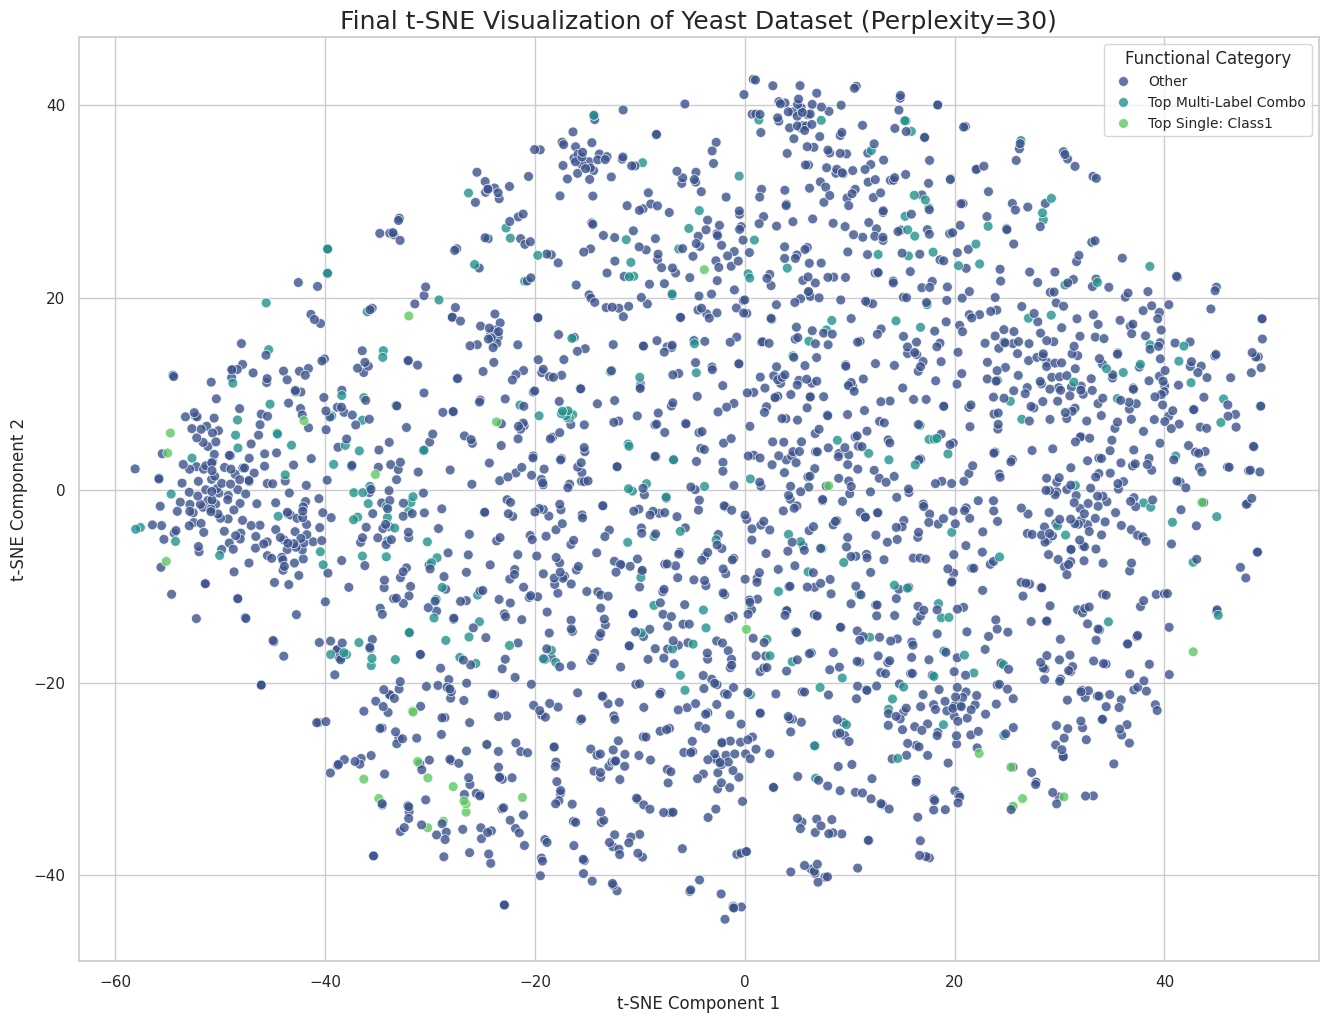

In [11]:
# Create the final t-SNE plot
plt.figure(figsize=(16, 12))
scatter = sns.scatterplot(
    x=X_tsne_final[:, 0],
    y=X_tsne_final[:, 1],
    hue=color_map_series,
    palette="viridis",
    s=50,
    alpha=0.8
)

plt.title('Final t-SNE Visualization of Yeast Dataset (Perplexity=30)', fontsize=18)
plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.legend(title='Functional Category', fontsize=10)
plt.show()

### 3. Veracity Inspection

We will now analyze the final t-SNE plot to identify potential data quality issues based on the visual clustering and separation of the functional categories.

**a. Noisy/Ambiguous Labels**

Noisy or ambiguous labels manifest as data points that are located deep within a cluster of a different category. This suggests their feature vectors (gene expression profiles) are highly similar to that cluster, but they have been assigned a conflicting label.

*   **Observation:** This plot is rich with examples of such ambiguity. For instance, consider the densest region on the far left (around x=-50). This area is dominated by the `Top Multi-Label Combo` (teal). However, we can clearly see several `Other` (dark blue) points mixed directly into the core of this region. Similarly, in the loose cluster of `Top Single: Class1` (light green) points at the bottom right (around x=30, y=-35), there are `Other` points interspersed. These points are essentially "impostors" in their respective neighborhoods.
*   **Interpretation:** For a classifier, these points are extremely challenging. A k-Nearest Neighbors (k-NN) model, for example, would almost certainly misclassify them, as their neighbors belong to a different class. This could be due to genuine biological ambiguity (a gene having a borderline or pleiotropic function) or an error in the original data labeling.

**b. Outliers**

Outliers are experiments with unusual expression profiles. In a t-SNE plot, they appear as points that are isolated and far from any of the main, dense clusters.

*   **Observation:** While this dataset forms a relatively continuous cloud, we can still identify several outliers. For example, there is a lone `Other` point at the very bottom of the plot (around x=-10, y=-48). Another few `Other` points are scattered on the far right periphery (e.g., around x=45, y=0). These points are distant from all major concentrations of data.
*   **Hypothesis:** These outliers could represent several scenarios in a biological context:
    1.  **Experimental Artifacts:** A failed experiment, contamination, or a measurement error could lead to a gene expression profile that is statistically very different from all others.
    2.  **Rare Cellular States:** The experiment might have captured a very rare or transient biological state, leading to a unique expression pattern not seen in other samples.
    3.  **Highly Specialized Genes:** These could be genes with unique functions that are not well-represented by the other samples in the dataset, causing them to have a distinct and isolated profile.

**c. Hard-to-Learn Samples**

Hard-to-learn samples are found in regions where points from different functional categories are thoroughly mixed, making it impossible to draw a simple decision boundary to separate them.

*   **Observation:** The entire central body of the plot is a massive hard-to-learn region. The vast majority of `Other` points (dark blue) are heavily intermingled with both the `Top Multi-Label Combo` (teal) and `Top Single: Class1` (light green) points. There is no clear line or curve that can cleanly separate these categories. The boundaries are fuzzy and overlapping everywhere.
*   **Interpretation:** This extensive mixing is the most significant challenge for any classifier. It visually demonstrates that many genes with different functional labels share highly similar expression profiles. A simple linear model would fail completely here, as it cannot create the complex, non-linear decision boundaries required. Even advanced models would likely struggle and have low confidence in their predictions for points in this central, mixed region, leading to a high classification error rate. This is a classic sign of high data complexity and overlapping class distributions.

In [12]:
# Initialize Isomap. We use the default n_neighbors=5.
isomap = Isomap(n_components=2, n_neighbors=5)

# Fit and transform the data
X_isomap = isomap.fit_transform(X_scaled)

### 2. Visualization

Here is the 2D scatter plot of the Isomap coordinates, using the same coloring scheme.

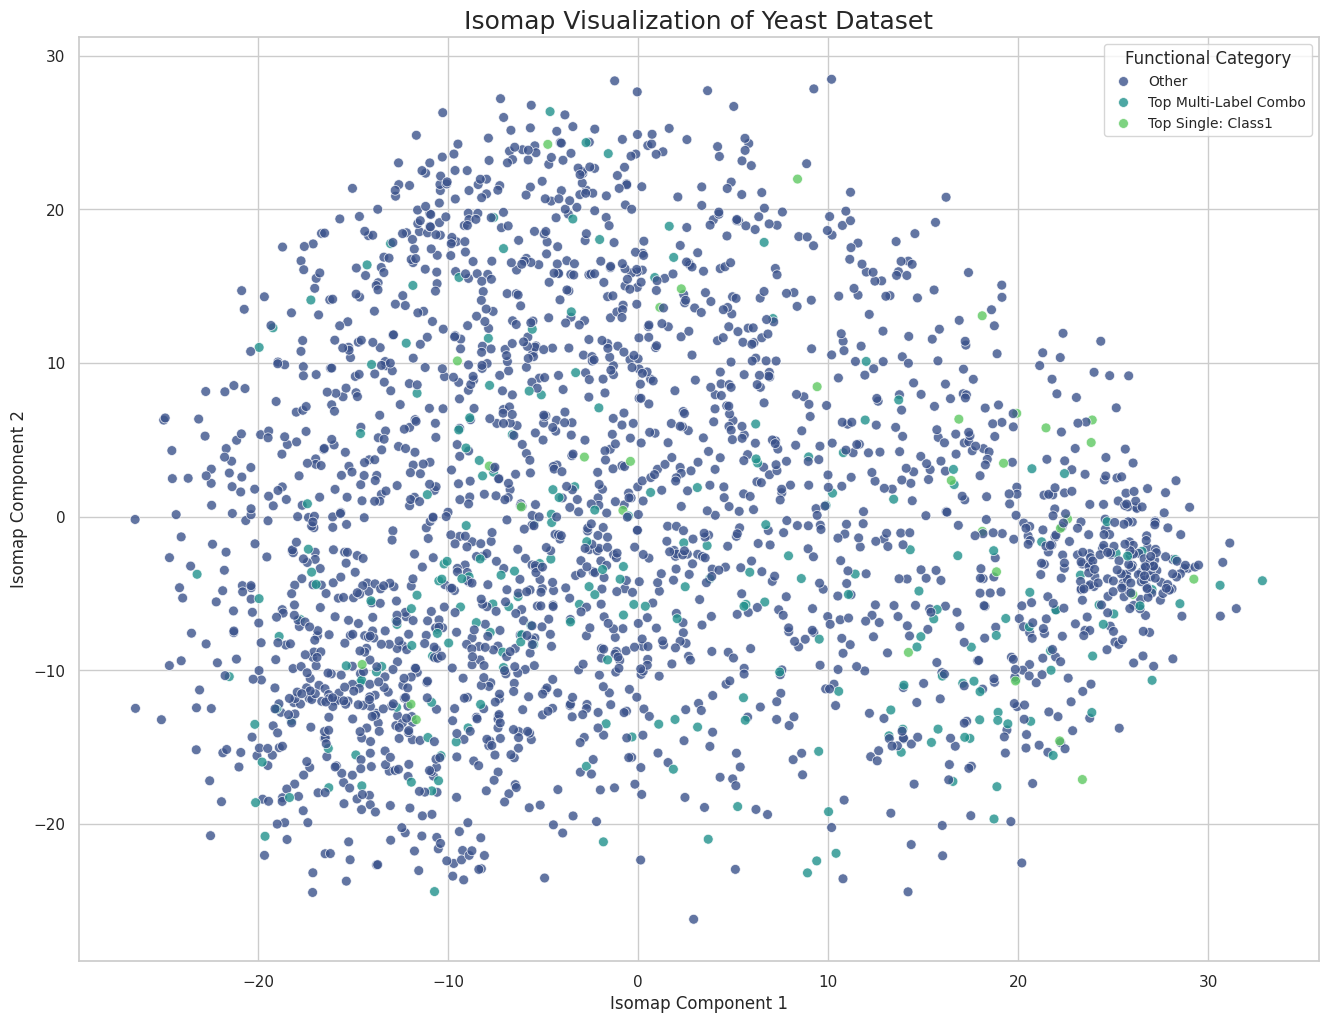

In [13]:
# Create the Isomap plot
plt.figure(figsize=(16, 12))
sns.scatterplot(
    x=X_isomap[:, 0],
    y=X_isomap[:, 1],
    hue=color_map_series,
    palette="viridis",
    s=50,
    alpha=0.8
)

plt.title('Isomap Visualization of Yeast Dataset', fontsize=18)
plt.xlabel('Isomap Component 1', fontsize=12)
plt.ylabel('Isomap Component 2', fontsize=12)
plt.legend(title='Functional Category', fontsize=10)
plt.show()


### 3. Comparison and Curvature

Now we compare the Isomap visualization to the t-SNE plot and discuss what it tells us about the underlying structure of the data, known as the data manifold.

**a. Comparison of Isomap and t-SNE**

*   **Which is better at revealing global structure?** **Isomap** is clearly superior at revealing the global, large-scale structure of the gene expression data.

*   **Analysis:**
    *   The t-SNE plot excels at creating distinct, visually separated clusters. It's a "local" view that emphasizes keeping similar points together, which is useful for identifying small, dense groups. However, the relative positions of these clusters and the large empty spaces between them are not geometrically meaningful.
    *   In sharp contrast, the Isomap plot reveals a single, continuous global structure. Instead of isolated islands, the data points form a large, connected shape that resembles a wide parabolic arc. This visualization suggests that the gene expression profiles vary smoothly along certain underlying dimensions rather than just forming discrete classes. For example, we can trace a path from the top-left of the arc to the dense cluster on the far right, and this path likely represents a meaningful progression in the high-dimensional feature space. Isomap provides the "world map," while t-SNE provides detailed "city maps."

**b. Data Manifold and Classification Difficulty**

*   **Concept of the Data Manifold:** The data manifold is a powerful concept in machine learning that posits that high-dimensional data (like our 103-feature gene data) often doesn't fill the entire space. Instead, it lies on or near a much lower-dimensional, non-linear (curved) surface embedded within that high-dimensional space. Manifold learning algorithms like Isomap are designed to "unroll" or flatten this surface to reveal its intrinsic geometry.

*   **Does the Isomap plot suggest a complex manifold?** Yes, the Isomap plot strongly indicates that the data lies on a **highly curved and complex manifold**.
    *   The overall structure is not a simple, shapeless blob; it is a well-defined, non-linear arc. This curvature is direct evidence of a non-linear manifold.
    *   Furthermore, the density is not uniform. There is a particularly dense region of points on the far right of the plot. This suggests the manifold is "warped," with some regions of the feature space being more populated than others.

*   **How does this relate to classification difficulty?** The complexity of the manifold is directly linked to the difficulty of the classification task.
    *   If the manifold were simple and flat, the different functional categories might occupy distinct, easily separable regions. A simple linear classifier (which creates flat decision boundaries like lines or planes) could perform well.
    *   However, because our data lies on this complex, curved manifold, the boundaries between the functional categories are themselves intrinsically non-linear and curved. The Isomap plot visualizes this challenge perfectly: the different colors are not cleanly separated into a "left side" and a "right side." Instead, they are mixed and distributed along the entire length of the curved structure. A linear classifier would fail because it cannot bend its decision boundary to follow the data's curved geometry. This visual evidence makes it clear that only powerful, non-linear models (like Kernel SVMs, Random Forests, or Neural Networks) that are capable of learning complex, curved decision boundaries would have a chance at successfully classifying this data.
---

## Conclusion

This analysis successfully utilized t-SNE and Isomap to visualize the complex structure of the Yeast gene expression dataset and identify key data veracity challenges.

*   **t-SNE** excelled at highlighting local cluster structures, making it easy to spot **outliers**, **noisy labels** (points within the wrong cluster), and **hard-to-learn regions** where clusters overlap significantly.
*   **Isomap** provided a superior view of the global data structure, revealing that the data lies on a **complex and curved manifold**. This insight explains *why* classification is inherently difficult for this dataset: the functional categories are intertwined along a non-linear surface, requiring sophisticated models to untangle them.

Together, these visualizations tell a compelling story about the challenges a machine learning practitioner would face. Any attempt to build a classifier for this data must account for these issues, potentially through data cleaning, outlier removal, and the selection of powerful, non-linear algorithms capable of learning the complex decision boundaries on the data manifold.